In [147]:
%matplotlib inline
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
 

from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,ExtraTreesClassifier,
                        AdaBoostClassifier,VotingClassifier)
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,KFold,StratifiedKFold
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import time 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import pandas as pd

In [148]:
def cls_NB(X_train,y_train,X_test, y_test):
    #Create a Gaussian Classifier
    clf = GaussianNB()

    # Train the model using the training sets 
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict_proba(X_test)    
    print("naive Bayes",log_loss(y_test, y_val_pred))
    
    return clf

In [149]:
train = pd.read_csv('../input/train.csv' )
test = pd.read_csv('../input/test.csv')

In [150]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


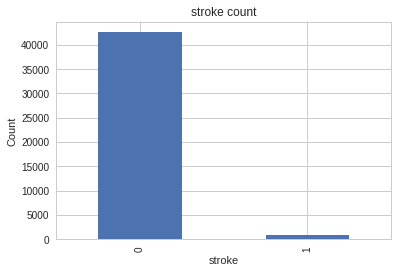

In [151]:
pd.value_counts(train['stroke']).plot.bar()
plt.title('stroke count')
plt.xlabel('stroke')
plt.ylabel('Count') 

In [152]:
train.isnull().any() #bmi,smoking_status has null value

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status        True
stroke               False
dtype: bool

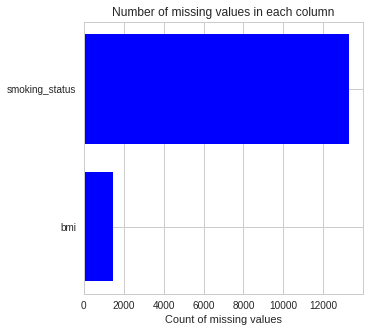

In [153]:
missing_df = train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(5,5))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

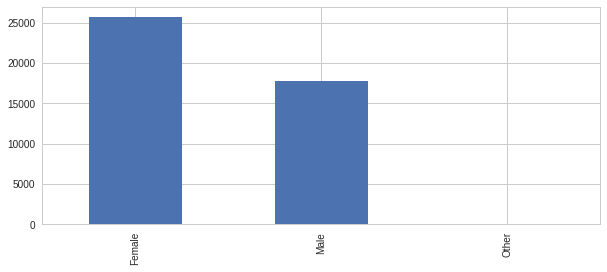

In [154]:
fig, ax = plt.subplots(figsize=(10,4))
pd.value_counts(train['gender']).plot(ax=ax,kind='bar')

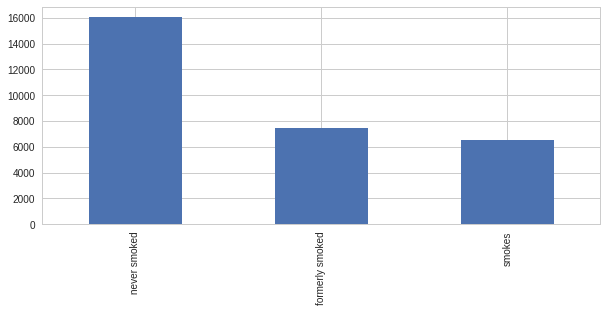

In [155]:
fig, ax = plt.subplots(figsize=(10,4))
pd.value_counts(train['smoking_status']).plot(ax=ax,kind='bar')

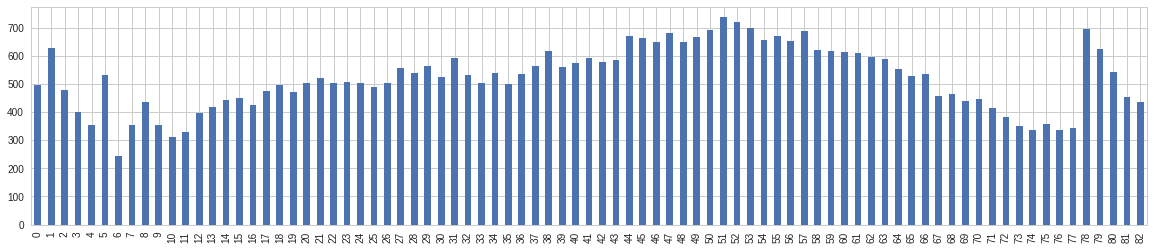

In [156]:
train['age'] = train['age'].astype('int')
fig, ax = plt.subplots(figsize=(20,4))
pd.value_counts(train['age']).sort_index().plot(ax=ax,kind='bar')

In [157]:
def PlotPie(df, nameOfFeature):
    labels = [str(df[nameOfFeature].unique()[i]) for i in range(df[nameOfFeature].nunique())]
    values = [df[nameOfFeature].value_counts()[i] for i in range(df[nameOfFeature].nunique())]

    trace=go.Pie(labels=labels,values=values)

    py.iplot([trace])

PlotPie(train,'stroke')

In [158]:
train['smoking_status'] = np.where((train['age'] < 10.0),0,train['smoking_status'] )
test['smoking_status'] = np.where((test['age'] < 10.0),0,test['smoking_status'] )
train.drop('bmi', axis = 1, inplace = True)
test.drop('bmi', axis = 1, inplace = True)

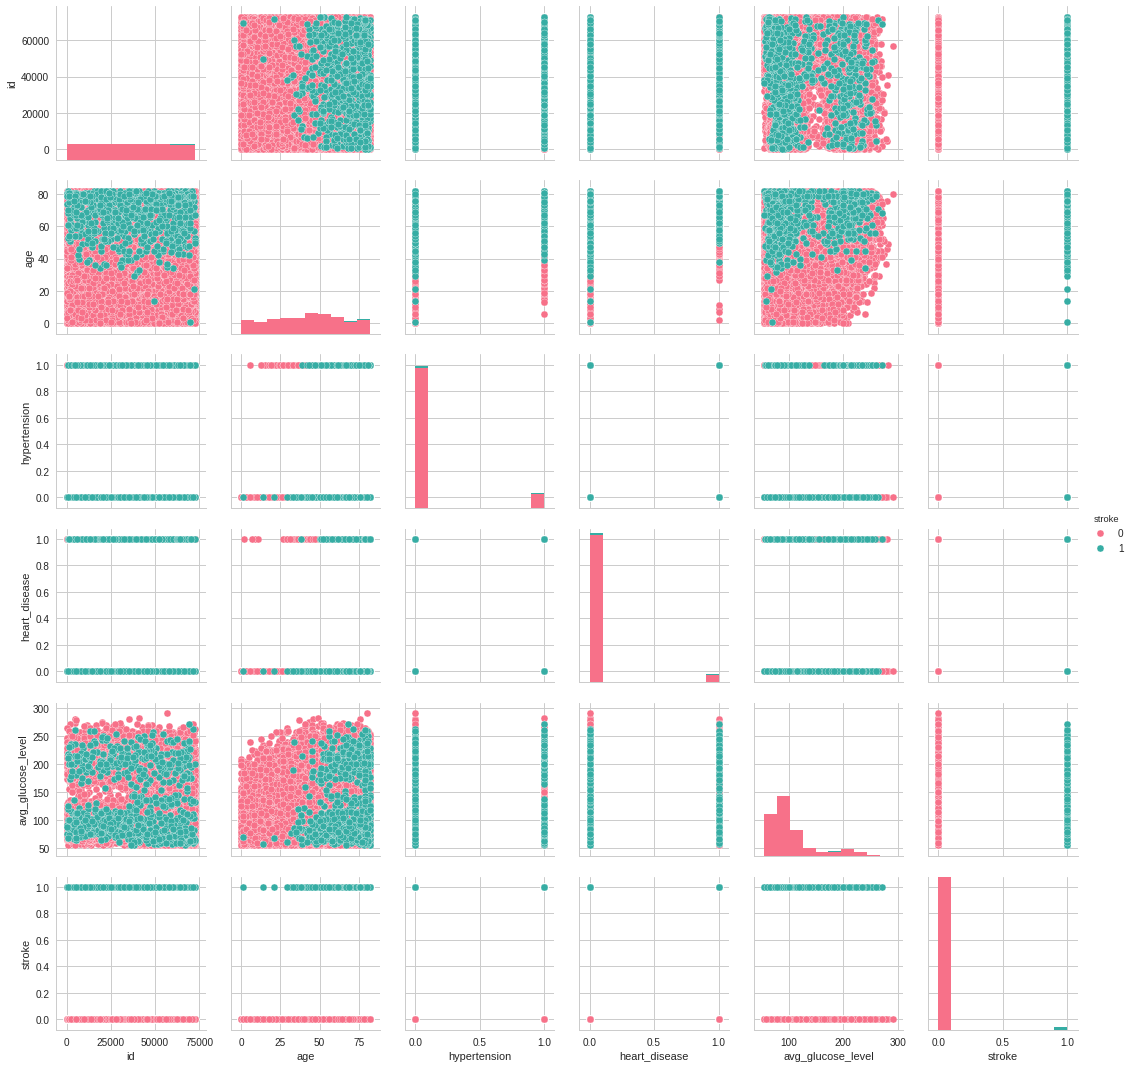

In [159]:
g = sns.pairplot(train, hue="stroke", palette="husl")

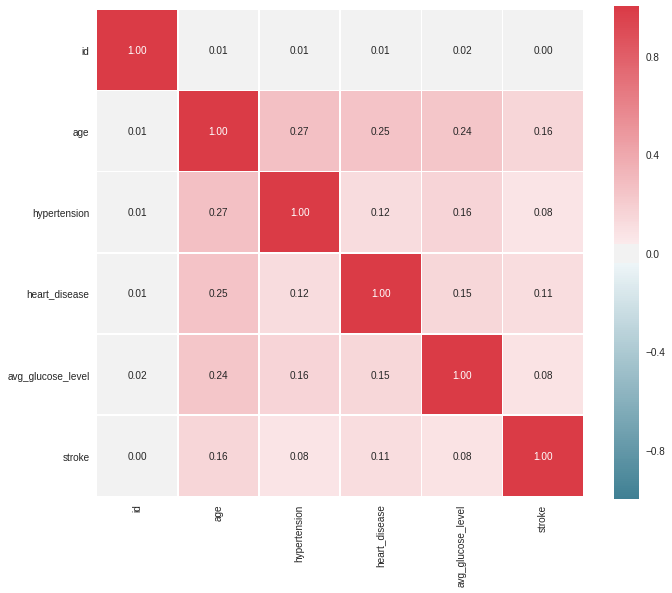

In [160]:
def HeatMap(df,x=True):
        correlations = df.corr()
        ## Create color map ranging between two colors
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        fig, ax = plt.subplots(figsize=(10, 10))
        fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',square=True, linewidths=.5, annot=x, cbar_kws={"shrink": .75})
        fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 10)
        fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
        plt.tight_layout()
        plt.show()

HeatMap(train,x=True)

In [162]:
test[test['avg_glucose_level'] > 280]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status


In [164]:
target = train['stroke']
train.drop('id', axis = 1, inplace = True)
train.drop('stroke', axis = 1, inplace = True)

target_y = test['id']
test.drop('id', axis = 1, inplace = True)

train['age'] = np.where((train['age'] < 1),0,train['age'] )
test['age'] = np.where((test['age'] < 1),0,test['age'] )

train_en = pd.get_dummies(train)
test_en = pd.get_dummies(test)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_en['avg_glucose_level'] = scaler.fit_transform(train_en[['avg_glucose_level']])
test_en['avg_glucose_level'] =  scaler.fit_transform(test_en[['avg_glucose_level']])

train_en['age'] = scaler.fit_transform(train_en[['age']])
test_en['age'] =  scaler.fit_transform(test_en[['age']])

In [169]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import EasyEnsemble
SEED = 7
def balanceData(features,labels):
    
    X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.3, random_state=0)
    
    sm = SMOTEENN(random_state=2)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
    return (X_train_res,y_train_res,X_test,y_test)

X_train_res, y_train_res,X_test,y_test = balanceData(train_en, target)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))

    
    return basedModels

def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)
        

models = GetBasedModel()
names,results = BasedLine2(X_train_res, y_train_res,models)
PlotBoxR().PlotResult(names,results)        



LR: 0.824978 (0.005858)


/home/ravi/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



LDA: 0.823566 (0.006088)
KNN: 0.986502 (0.001723)
CART: 0.978369 (0.017198)
NB: 0.646774 (0.004453)


In [27]:
clf  = LogisticRegression(C=.0001)
clf.fit(X_train_res, y_train_res)
predictions = clf.predict_proba(X_test)[:,1] 
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, predictions))
# Save the file
y_test = clf.predict_proba(test_en)[:,1]
df_sub = pd.DataFrame({'id': target_y, 'stroke': y_test})
df_sub.to_csv('logistReg.csv', index=False)

ValueError: Found array with dim 3. Estimator expected <= 2.